In this tutorial I’ll attempt to briefly summarise the main concepts from the paper and share few results which I obtained from re-doing in similar fashion using Keras.

This code was ran on google colab successfully - using python 3.6 and GPU enabled.

##Neural Style Transfer

###What is Style Transfer?
Imagine that you clicked a photo of Seattle skyline (let us call this as **content image**), and you want to apply some painting style to it in order to make it more pleasing artistic image. To achive this say you selected pastel, oceanic, and foamy style image of the Hokusai’s The Great Wave of Kanagawa - let us call this **style image**. The process of transfering the patterns, texture or brush strokes (style) from style image to the content image without loss of actual aspects of content image is called style transfer. 

![painting](https://hackathonprojects.files.wordpress.com/2017/04/greatwave.jpg =300x200) + ![scene](https://hackathonprojects.files.wordpress.com/2017/04/skyline.jpg?w=1024&h=683 =300x200) = ![new image](https://hackathonprojects.files.wordpress.com/2017/04/skyline1.png =300x200) 


The first major step in this field was introduced in the paper *A Neural Algorithm of Artistic Style* which shows that the task of transferring the style from one image to another can be posed as an optimisation problem while retaining all important details of content image. 

**Note** : Style transfer should not be confused with transformation which is applied to the picture only in the color space (example - as in instagram filters)

Few terminologies - style image, content image and target image in the entire tutoial

1. *Style image: The image whose style we want to transfer (S)*
2. *Content Image: the image on which we want to transfer the style (C)*
3. *Target Image: The random noise image which will be our desired image after n number of iterations or back propogation (T)*

**Why/how optimization problem?**

Remember!
- We do not want to lose the details of content image during this process. 

So suppose we have a function $L_{content}$ which measures how different the content of two images are. Thus this function should compare the target image and content image and the differences should be minimized. 

$L_{content}$$(C,T)$ $\approx 0$ becomes our content loss function.

- We want to style of two images to be as close as possible. 

Now suppose we have another function $L_{style}$ which measures how close style in two images are. Here we would comapre style image and target image and try to minimize the differences.

$L_{style}$$(S,T)$$\approx 0$ becomes our style loss function.

We are simply taking ?advantage of ?backpropagation to minimize two defined loss values.We starts with a random noise image and with every training or an iteration we get closer and closer to the desired image.

**Note** : Losses are not based on per-pixel differences between images, but instead in terms of higher level semantic differences. (more below @)



### CNN Overview
Before we start with the style transfer algorithm lets us have a berif overview on the Convolutional Neural Networks, one of the most effective architecture for object recognition and detection.

The CNN architecture has different types of layers
1. Convolution Layer
In this layer a filter (matrix of numbers) will colvoule over an image or a feature map, then a weighted avergae is applied followed by a nonlinear transformation. This generates a feature map. This feature map will lose the information of the pixel in the image but will hold the information of shape, textures, objects etc. So after every convolution layer we can have a feature map.
2. Pooling Layer
Pooling layer helps in reduction of the dimensions of the feature maps.
3. Fully Conntected Layer
This is a neural network which is generally placed at the end of the network which will enable us to detect and recognise the objects.
For further reading on CNN I would suggest the following. It is better to have a good understanding of the architecture before diving into the style transfer algorithm.

































Now its time to look at some code and the details of the Style transfer

We begin byl uploading the two images(Style and content) from our computer to the google colab server. Please select the images from your system when the propmt appears

In [11]:

# upload the files to the google colab server
# We will load one content image and one style image to the server
# Below code will prompt u to choose files from your computer
# Once the files are uploaded it will show the message that files are uploaded
# use the google crome browser for this code snippet

from google.colab import files
print("Upload the content and style image")
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


Upload the content and style image


Saving content_2.png to content_2 (1).png
Saving style_2.png to style_2 (2).png
User uploaded file "content_2.png" with length 143036 bytes
User uploaded file "style_2.png" with length 571856 bytes


This section imports all the libraries required for the tutorial

In [0]:
# Library Import
import matplotlib.image as mpimg  ## save_img from keras was erroring out so i have used imsave funtion from the matplotlib library
import matplotlib.pyplot as plt ## plot the images using matplotlib 
from keras.preprocessing.image import load_img #loads the image
from keras.preprocessing.image import img_to_array #reshapes the array (used in preprocess function)
import numpy as np #used for multiple functionalities
from keras import backend as K
import time
from scipy.optimize import fmin_l_bfgs_b #optimizer
from PIL import Image
from keras.applications import vgg19 #import the vgg19 from keras


Now we are done with importing the libraries and uploading our images 

Let us have a look at images by plotting both the content and style images.

In [0]:
# Set the content image path and style image path
# this is content image
base_image_path = 'content_2.png' #cat.jpg' 

# this is a style image
style_reference_image_path = 'style_2.png' 

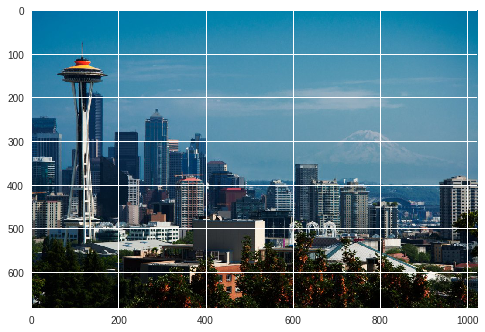

In [14]:
content_image = load_img(base_image_path)
plt.imshow(content_image)

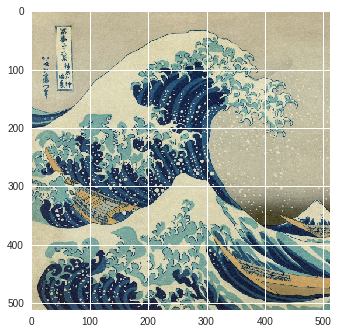

In [15]:
style_image = load_img(style_reference_image_path)
plt.imshow(style_image)

We will set image hieght to 400 and then set the width with the same aspect ratio

In [0]:
# get the width and the height of the content image
width, height = content_image.size

# Set the hight to 400
img_nrows = 400

#set the width according to the height
img_ncols = int(width * img_nrows / height)

Before we proceedfurther we should do some tranformation to the image to pass it through the VGG Network

Subtract the mean RGB value (computed previously on the ImageNet training set and easily obtainable from Google searches) from each pixel.
Flip the ordering of the multi-dimensional array from RGB to BGR (the ordering used in the paper).

For passing all the three style content and target images onto the network we will have to resize and reshape the images.

The preprocess function will do all this for us

The output after the optimization is done will be a tensor which need to be converted to a image, To do this we shall use the de process function

In [0]:
# util function to open, resize and format pictures into appropriate tensors

def preprocess_image(image_path):
    print(image_path)
    # Load the image into the desired size 
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    print("Initial Size of the Image",img.size)
    # Convert the matrix to numpy array with a 3rd dimension
    
    #adds a 3rd dimestion to the imag
    img = img_to_array(img)
    print("after adding the third dimension",img.shape)
    
    #expands the dimension on axis 0
    
    img = np.expand_dims(img, axis=0)
    print("after expading the dimensions",img.shape)
    img = vgg19.preprocess_input(img)
    return img
  
  
  
# util function to convert a tensor into a valid image
def deprocess_image(x):
    
    import numpy as np
    # Checks if the Heras has a Channel first or a channel last setting
    if K.image_data_format() == 'channels_first':
        # if its Channel first then we reshape with 3 in the start
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        # if its Channel last then we reshape with 3 in the start
        x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x


In the sext section we  will convert the style and content images into keras variables, create a place holder variable to store the final image (target image) and then create a tensor of all the three images.

In [20]:
# get tensor representations of our images

base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))

# this will contain our generated image
if K.image_data_format() == 'channels_first':
    combination_image = K.placeholder((1, 3, img_nrows, img_ncols))
else:
    combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)
print("Our input tensor: ", input_tensor)

content_2.png
Initial Size of the Image (599, 400)
after adding the third dimension (400, 599, 3)
after expading the dimensions (1, 400, 599, 3)
style_2.png
Initial Size of the Image (599, 400)
after adding the third dimension (400, 599, 3)
after expading the dimensions (1, 400, 599, 3)
Our input tensor:  Tensor("concat:0", shape=(3, 400, 599, 3), dtype=float32)


Till now we have loaded our images, changed the size and shapes of it and converted it to a tensor. 


##Approach

To perform the Syle Transfer using Neural Networks we will need the following
1. Pretrained Network
2. Defining 3-Loss functions - Styles loss, Content loss and total variation loss
3. Selecting the layers for content ans styles
3. Optimizer (minimizing the loss) 


####Steps
1. The target image is first initialised to a random image
2. The target image, content image and the style images are then passed through a pretrained image classification network
3. As we are interested in styles and textures and not the image classification we will exclude the fully connected layers and the softmax classifiers from the network.
4. The outputs from the earlier layers in the network which are nothing but feature maps will be used to optimise the losses
5. Now the loss between feature map of the style image and the feature map of target image is minimised, called as style loss.
6. When the loss between the feature map of content image and that of target image is minimised is called as content loss.
7. By the end of a few iterations we will have the target image which will have the style of style image and the content of content image.



####Pre-Trained Network

In this tutorial we shall use a VGG 19 Network with weights optimised for image net. Once the model is loaded we can have a look at all the layers. VGG Network has

1. 16 layers with weights that can be learnt, hence the name. 
2. 5 Convolution blocks with total 13 convolution layers (Block 1 and 2 having 2 convolution layers and Block 3,4 and 5 have having 3 convolution layers).
3. 2 Fully Conttected Layers

Below is the architecture of VGG 19



![cvgg19](https://shafeentejani.github.io/assets/images/style_transfer/vgg_architecture_vertical.png)


As we are interested only in textures and strokes and semantics these will be available in the feature maps generated  the earlier layers in the network. 
The last layers of the network (Fully Connected Layers)is not used. It will have high level features that are used to identify the objects.

Let us Start by importing  the network from keras

In [21]:
from keras.applications import vgg19
# Top = False exclued the fully connected layers
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')

# Look at the Summary of the Model
model.summary()

# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
outputs_dict


80142336/80134624 [==============================] - 8s 0us/step
Model loaded.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_______________________________________________________________

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 400, 599, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 400, 599, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 200, 299, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 200, 299, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 200, 299, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 100, 149, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 100, 149, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 100, 149, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 100, 149, 256) dtype=float32>,
 'block3_conv4': <tf.Tensor 'block3_conv4/Relu:0' shape=(3, 100, 149, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 50, 74, 256) dtype=float32>,
 

## Define the Losses
Why do we use the outputs of the intermediate layes of a pretrained image classifcation network?

The network which is built to classify the images takes and input as an image, does a transformation of the pixels to intermediate semantic representation of the image, which enables it to recognise the objects.

For example if we pass 2 different dog images to the network,after being passed through multiple layers their semantic representations will be very similar. 

### Content Loss
Given a chosen content layer l, the content loss is defined as the euclidean distance between the feature map $C^l$ of our content image C and the feature map $T^l$ of our generated image T. When the content representation of C and T are exactly the same this loss becomes 0.

$L_{content} = {\frac{1}{2}}{\sum}(C^l-T^l)^2$


### Style Loss
Now to extract styles from these semantic representations or feature maps we should throw away the spatial information from these feature maps.
For example If we have 10 feature map of size 5X5 from a layer then we will take a sum of dot product of each channel with everyother channel and create a matrix of size 10X10

![grammatrix](https://drive.google.com/uc?id=12XFofiVO80lfkIIkVh65AdeB8N-pLdC2)

The concept is very similar to the content loss but , except that instead of comparing the semantic representation we compare the new matrix that we formed above also called gram matrix of the semantic representaion.

The name gram matrix might seem to have a feel of complexity but it is a simple dot product of the two feature maps or intermediate representaions.

Given a chosen style layer l, the style loss is defined as the euclidean distance between the Gram matrix $GS^l$ of the feature map of our style image S and the Gram matrix $GT^l$ of the feature map of our generated image T. When considering multiple style layers we can simply take the sum of the losses at each layer.

$L_{style} = {\frac{1}{2}}{\sum}(GS^l-GT^l)^2$

### Total Loss
The total loss can then be written as a weighted sum of the both the style and content losses, where the weights can be adjusted to preserve more of the style or more of the content.

$L_{total} = \alpha L_{content}+\beta L_{style}$

In [0]:
# compute the neural style loss
# first we need to define 4 util functions
#Style loass is also defined as the euclidian distance between the gram matrix G1 of the feature map of out style image S an dthe Gram matrix A1 of the feature map of our target image Y
#What is a gram matrx
#Its othing but dot product of the feature activation
#when the dot product is low we know the the same feature in the layer dont activate for both the images

def gram_matrix(x):
    assert K.ndim(x) == 3
    if K.image_data_format() == 'channels_first':
        features = K.batch_flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, combination,h,w):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = h * w
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))


# Content Loss
# Content loass is defined as as euclidian distance between the feature map F1 of content image C and feature map P1 of our generated image Y
# when the Loss of this functionis 0 then we have the same content in both the content image and the target image
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

#Total loss is a weighted sum of style loss and the content loss
#We can adujust the weights based on how much content and style we need 
def total_variation_loss(x):
    assert K.ndim(x) == 4
    if K.image_data_format() == 'channels_first':
        a = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, 1:, :img_ncols - 1])
        b = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, :img_nrows - 1, 1:])
    else:
        a = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
        b = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))



# combine these loss functions into a single scalar
loss = K.variable(0.)


### Selecting the layers for content and styles
We can pass our conent and style image to the network and then reconstruct the image from the feature map to see what information is bieng stored in the feature maps.

#### Content reconstruction
In order to create new image using a blend of content and style, we first need a procedure/method that creates a new image which has content (i.e. the image scene) that matches the content of some other image; this method is known as content reconstruction.  Reconstructing an image from its content can be done using CNNs, and it’s more straightforward than the reconstruction of style.

First, define a set of feature maps that will be used as criteria in content assessment.  This is done by 
1. Choosing a layer $l$ from the model. 
2. Next, get the values of these feature maps for a content image C by passing the content image through the model; the feature maps at layer l will be the target feature maps $C^l$.  
3. Next, pass a white noise image T through the model, and get the white noise feature maps $T^l$.  
4. Then, compare the target feature maps with the white noise feature maps using a loss function similar to mean squared error

$L_{content}(C,T,l) =\frac{1}{2} \sum \limits_{i,j}(T^l_{ij}-C^l_{ij})^2$

Differentiating this loss function with respect to the white noise image will yield derivatives of the loss with respect to pixels of the image.  These derivatives can be used to change the white noise image so it has content closer to the content of the content image according to the feature maps in layer l.  After the changes to the white noise image have been made, the loss is measured again and changes are made to the white noise image.  This is done until the white noise image has a scene that matches the scene of the content image.  This procedure can be applied using a set of feature maps from any layer of the CNN.


Reconstructions that use earlier layers in the network preserve pixel details, whereas reconstructions with later layers lose details but preserve salient features (e.g. the reconstruction of an image that contained a house will still contain a house, but it might have something like a blurry window).

#### Style reconstruction
Reconstructing style of an image is less intuitive than reconstructing content, but it uses the same principles. As mentioned earlier that for style loss we will be using the gram matrix of feature maps instead of the feature maps it self
It turns out that the original authors were experts at understanding how textures are represented in images. They knew that this Gram matrix would be a good way to define the texture/style of the image.

If we had two images we can get two Gram matrices, compare them with some sort of loss function, and then use calculus with the loss and pixels of one of the images to change that image to have style more like the other.  Specifically the loss for a layer l and style image a would be

$L_{style}(S,T,l) =\frac{1}{2}\sum\limits_{i,j} (GT_{ij}^l-GS_{ij}^l)^2$


Style generation can be done using multiple layers of the network to take advantage of different aspects of style picked up by the CNN.  To do this, we define a set of layers $\lambda$ that we use to generate the style.  Then we define our new style loss to be

$L_{style}(S,T) = \sum\limits_{l\in \lambda}L_{style}(S,T,l)$

The iterative process of changing a white noise image based off  derivatives of a loss with respect to the pixels of the white noise image can be used with the style loss to create new images that have a style strikingly similar to the style image.

We then introduce an Evaluator class that computes loss and gradients in one pass while retrieving them via two separate functions, loss and grads. This is done because scipy.optimize requires separate functions for loss and gradients, but computing them separately would be inefficient.

In [0]:

# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.


class Evaluator(object):

    def __init__(self, f_outputs, height, width):
        self.loss_value = None
        self.grads_values = None
        self.f_outputs = f_outputs
        self.height = height
        self.width = width

    def eval_loss_and_grads(self, x):
        x = x.reshape((1, self.height, self.width, 3))
        outs = self.f_outputs([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        return loss_value, grad_values

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = self.eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

Let us define the method for reconstructing the images from multiple layers of VGG19 to select the right layer for our style transfer. 

In [0]:
def content_image_reconstruction(layer_name,layers):
  layer_features = layers[layer_name]
  content_image_features = layer_features[0, :, :, :]
  combination_features = layer_features[2, :, :, :]

  loss = content_loss(content_image_features,
                      combination_features)

  grads = K.gradients(loss, combination_image)
  outputs = [loss]
  outputs += grads
  f_output = K.function([combination_image], outputs)
  
  evaluator = Evaluator(f_output, img_nrows, img_ncols)  

  # white noise image
  x = np.random.uniform(0, 255, (1, img_nrows, img_ncols, 3))

  iterations = 10
  
  # print layer-name & number of iterations
  title = layer_name + " (%d-iters):" % (iterations)
  print(title)
  print('='*len(title))
  for i in range(iterations):
      start_time = time.time()
      x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                       fprime=evaluator.grads, maxfun=20)
      end_time = time.time()
      
      # print loss value & time taken in iteration i
      # format: loss(time-in-seconds)
      print("%.2f(%ds)," % (min_val, end_time - start_time), end='')
      
      # print new line so that we don't exceed way out of screen
      if (i % 10 == 9):
        print()
  print()
  img = deprocess_image(x.copy())
  plt.imshow(img)
  plt.show()

We have selected 8 layers from different blocks, let us have a look at the results of content reconstruction

In [25]:
layer_names = ['block1_conv2'
               ,'block2_conv2'
               ,'block3_conv2', 'block3_conv4'
               ,'block4_conv2', 'block4_conv4'
               ,'block5_conv2', 'block5_conv4']
for cnn_layer in layer_names:
  content_image_reconstruction(cnn_layer, outputs_dict)

We saw that in block 4 and block 5 most of the cotent information was lost. we can select block 3 conv 2 or 4 

Now let us define the style reconstruction,  

In [0]:
def style_image_reconstruction(layer_names,layers):
    loss = K.variable(0.)
    for layer_name in layer_names:
      layer_features = layers[layer_name]
      style_features = layer_features[1, :, :, :]
      combination_features = layer_features[2, :, :, :]

      loss += style_loss(style_features, combination_features, img_nrows, img_ncols)      

    grads = K.gradients(loss, combination_image)
    outputs = [loss]
    outputs += grads
    f_output = K.function([combination_image], outputs)

    evaluator = Evaluator(f_output, img_nrows, img_ncols)

    # white noise image
    x = np.random.uniform(0, 255, (1, img_nrows, img_ncols, 3))

    iterations = 20

    # print layer-name & number of iterations
    title = ",".join(layer_names) + " (%d-iters):" % (iterations)
    print(title)
    print('='*len(title))
    for i in range(iterations):
        start_time = time.time()
        x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                         fprime=evaluator.grads, maxfun=20)
        end_time = time.time()

        # print loss value & time taken in iteration i
        # format: loss(time-in-seconds)
        print("%.2f(%ds)," % (min_val, end_time - start_time), end='')

        # print new line so that we don't exceed way out of screen
        if (i % 10 == 9):
          print()
    print()
    img = deprocess_image(x.copy())
    plt.imshow(img)
    plt.show()

For style reconstruction we can chosse a set of layers instead of single layers, Let us have a look at the results of these. We have selected only 3 sets because to reduce the time and processing

block1_conv1,block2_conv1,block3_conv1,block4_conv1,block5_conv1 (20-iters):
27929020416.00(18s),11976799232.00(18s),8078244864.00(19s),6376060928.00(18s),5103688192.00(18s),4377578496.00(18s),3803773440.00(18s),3299500800.00(18s),2908831744.00(18s),2559199232.00(18s),
2281824000.00(18s),2052601728.00(18s),1875361664.00(18s),1713892736.00(18s),1577999488.00(18s),1460909568.00(18s),1369913344.00(18s),1283776640.00(18s),1185415296.00(18s),1109388928.00(18s),



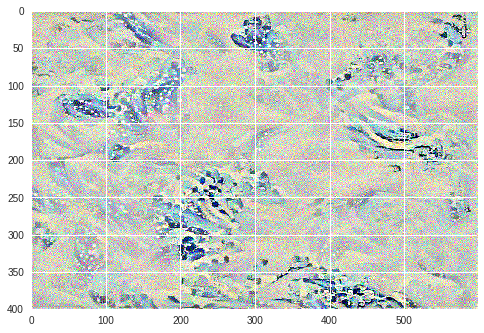

block1_conv2,block2_conv2,block3_conv2,block4_conv2,block5_conv2 (20-iters):
14354596864.00(18s),5743349248.00(18s),3389122816.00(18s),2099473536.00(18s),1509501824.00(18s),1129118208.00(18s),895387712.00(18s),726904320.00(18s),603647936.00(18s),488603104.00(18s),
415018496.00(18s),359606176.00(18s),314162784.00(18s),282874688.00(18s),260196336.00(18s),232122192.00(18s),213342160.00(18s),195754608.00(18s),182000336.00(18s),171274832.00(18s),



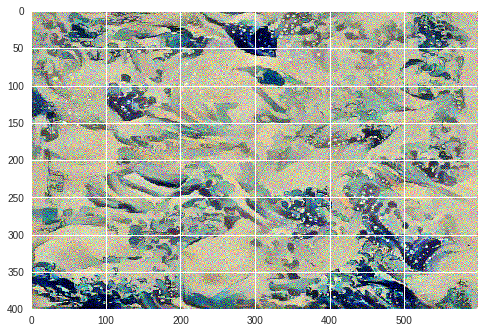

block3_conv2,block4_conv2,block5_conv2 (20-iters):
6407783936.00(16s),2203307776.00(16s),1351133568.00(16s),944529856.00(16s),742342080.00(16s),626926272.00(16s),548108416.00(16s),491501120.00(16s),442933024.00(16s),406298176.00(16s),
372431360.00(16s),347997152.00(16s),326660640.00(16s),309503520.00(16s),292804512.00(16s),279014816.00(16s),267494704.00(16s),254527552.00(16s),244098944.00(16s),235773264.00(16s),



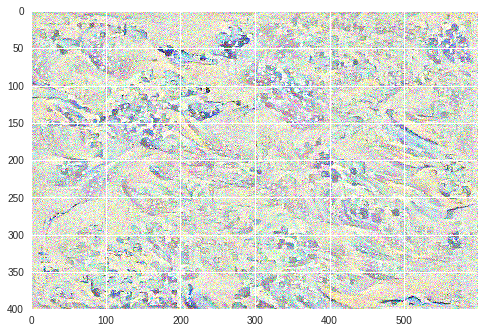

In [27]:
layer_names = [('block1_conv1', 'block2_conv1','block3_conv1', 'block4_conv1', 'block5_conv1')
               ,('block1_conv2', 'block2_conv2','block3_conv2', 'block4_conv2', 'block5_conv2')
               ,('block3_conv2', 'block4_conv2', 'block5_conv2')]
for cnn_layer in layer_names:
  style_image_reconstruction(cnn_layer,outputs_dict)

Now we will set the variables or weights for the loss. The content weight tells how much 

In [0]:
# Set the content weight
content_weight = 0.025

# Set the style weight
style_weight = 5.0

#Set the total variation weight
total_variation_weight = 1.0

Now we’re finally ready to solve our optimisation problem. This combination image begins its life as a random collection of (valid) pixels, and we use the L-BFGS algorithm (a quasi-Newton algorithm that’s significantly quicker to converge than standard gradient descent) to iteratively improve upon it.

We stop after 10 iterations because the output looks good to me and the loss stops reducing significantly.

In [33]:
# This Section has loss for the Content
# We consider the 2nd convolution layer of the block 5 for the content loss
layer_features = outputs_dict['block3_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(base_image_features,combination_features)

# This Section has loss for the Content
# We consider the 1st convolution layer of the block 1 to 5 for the content loss
feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features,img_nrows,img_ncols)
    loss += (style_weight / len(feature_layers)) * sl

#get the total variation loss
loss += total_variation_weight * total_variation_loss(combination_image)

# get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)

evaluator = Evaluator(f_outputs,img_nrows,img_ncols)

iterations = 100

#This will be added as prefix to the name of the new image
result_prefix = 'res'+'_CW'+str(content_weight)+'_SW'+ str(style_weight)+'_TW'+str(total_variation_weight)
result_prefix


# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
 
x = preprocess_image(base_image_path)
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # save current generated image
    img = deprocess_image(x.copy())
    fname = result_prefix + '_at_iteration_%d.png' % i
    mpimg.imsave(fname, img)
    files.download((fname))
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))
    

content_2.png
Initial Size of the Image (599, 400)
after adding the third dimension (400, 599, 3)
after expading the dimensions (1, 400, 599, 3)
Start of iteration 0
Current loss value: 56839823000.0
Image saved as res_CW0.025_SW5.0_TW1.0_at_iteration_0.png
Iteration 0 completed in 29s
Start of iteration 1
Current loss value: 39342530000.0
Image saved as res_CW0.025_SW5.0_TW1.0_at_iteration_1.png
Iteration 1 completed in 29s
Start of iteration 2
Current loss value: 31706747000.0
Image saved as res_CW0.025_SW5.0_TW1.0_at_iteration_2.png
Iteration 2 completed in 27s
Start of iteration 3
Current loss value: 28105116000.0
Image saved as res_CW0.025_SW5.0_TW1.0_at_iteration_3.png
Iteration 3 completed in 26s
Start of iteration 4
Current loss value: 26436018000.0
Image saved as res_CW0.025_SW5.0_TW1.0_at_iteration_4.png
Iteration 4 completed in 28s
Start of iteration 5
Current loss value: 25508463000.0
Image saved as res_CW0.025_SW5.0_TW1.0_at_iteration_5.png
Iteration 5 completed in 26s
Sta

Current loss value: 23886719000.0
Image saved as res_CW0.025_SW5.0_TW1.0_at_iteration_25.png
Iteration 25 completed in 27s
Start of iteration 26
Current loss value: 23880905000.0
Image saved as res_CW0.025_SW5.0_TW1.0_at_iteration_26.png
Iteration 26 completed in 26s
Start of iteration 27
Current loss value: 23875932000.0
Image saved as res_CW0.025_SW5.0_TW1.0_at_iteration_27.png
Iteration 27 completed in 27s
Start of iteration 28
Current loss value: 23871668000.0
Image saved as res_CW0.025_SW5.0_TW1.0_at_iteration_28.png
Iteration 28 completed in 26s
Start of iteration 29
Current loss value: 23867929000.0
Image saved as res_CW0.025_SW5.0_TW1.0_at_iteration_29.png
Iteration 29 completed in 27s
Start of iteration 30
Current loss value: 23864844000.0
Image saved as res_CW0.025_SW5.0_TW1.0_at_iteration_30.png
Iteration 30 completed in 26s
Start of iteration 31
Current loss value: 23862272000.0
Image saved as res_CW0.025_SW5.0_TW1.0_at_iteration_31.png
Iteration 31 completed in 26s
Start o

Current loss value: 23843465000.0
Image saved as res_CW0.025_SW5.0_TW1.0_at_iteration_51.png
Iteration 51 completed in 27s
Start of iteration 52
Current loss value: 23843041000.0
Image saved as res_CW0.025_SW5.0_TW1.0_at_iteration_52.png
Iteration 52 completed in 30s
Start of iteration 53
Current loss value: 23842615000.0
Image saved as res_CW0.025_SW5.0_TW1.0_at_iteration_53.png
Iteration 53 completed in 27s
Start of iteration 54
Current loss value: 23842185000.0
Image saved as res_CW0.025_SW5.0_TW1.0_at_iteration_54.png
Iteration 54 completed in 26s
Start of iteration 55
Current loss value: 23841833000.0
Image saved as res_CW0.025_SW5.0_TW1.0_at_iteration_55.png
Iteration 55 completed in 26s
Start of iteration 56
Current loss value: 23841510000.0
Image saved as res_CW0.025_SW5.0_TW1.0_at_iteration_56.png
Iteration 56 completed in 26s
Start of iteration 57
Current loss value: 23841210000.0
Image saved as res_CW0.025_SW5.0_TW1.0_at_iteration_57.png
Iteration 57 completed in 26s
Start o

Current loss value: 23838670000.0
Image saved as res_CW0.025_SW5.0_TW1.0_at_iteration_77.png
Iteration 77 completed in 25s
Start of iteration 78
Current loss value: 23838670000.0
Image saved as res_CW0.025_SW5.0_TW1.0_at_iteration_78.png
Iteration 78 completed in 26s
Start of iteration 79
Current loss value: 23838670000.0
Image saved as res_CW0.025_SW5.0_TW1.0_at_iteration_79.png
Iteration 79 completed in 23s
Start of iteration 80
Current loss value: 23838670000.0
Image saved as res_CW0.025_SW5.0_TW1.0_at_iteration_80.png
Iteration 80 completed in 25s
Start of iteration 81
Current loss value: 23838670000.0
Image saved as res_CW0.025_SW5.0_TW1.0_at_iteration_81.png
Iteration 81 completed in 25s
Start of iteration 82
Current loss value: 23838670000.0
Image saved as res_CW0.025_SW5.0_TW1.0_at_iteration_82.png
Iteration 82 completed in 23s
Start of iteration 83
Current loss value: 23838670000.0
Image saved as res_CW0.025_SW5.0_TW1.0_at_iteration_83.png
Iteration 83 completed in 25s
Start o